In [1]:

%load_ext autoreload
%autoreload 2
import bnl

## Tests for checking metrics are working

In [3]:
def simple_hierarchy():
    # Level 0 - coarsest segmentation
    level0_itvls = [(0.0, 10.0), (10.0, 20.0)]
    level0_labels = ["A", "B"]

    # Level 1 - finer segmentation
    level1_itvls = [(0.0, 6.0), (6.0, 10.0), (10.0, 16.0), (16.0, 20.0)]
    level1_labels = ["A1", "A2", "B1", "B2"]

    # Level 2 - finest segmentation
    level2_itvls = [
        (0.0, 3),
        (3, 5.0),
        (5.0, 7.5),
        (7.5, 10.0),
        (10.0, 13),
        (13, 15.0),
        (15.0, 17.5),
        (17.5, 20.0),
    ]
    level2_labels = ["A1a", "A1b", "A2a", "A2b", "B1a", "B1b", "B2a", "B2b"]

    hier_itvls = [level0_itvls, level1_itvls, level2_itvls]
    hier_labels = [level0_labels, level1_labels, level2_labels]

    return bnl.H(hier_itvls, hier_labels)



In [4]:
h = simple_hierarchy()

(<Figure size 500x170 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

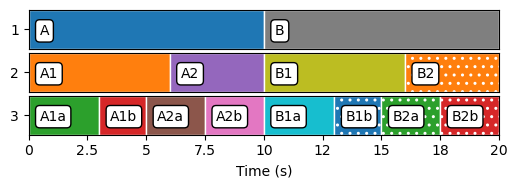

In [5]:
h.plot()

In [7]:
s1 = h.levels[1]
s2 = h.levels[2]
bnl.fmtr.entropy(s1.itvls, s1.labels)

1.3661588475692017

In [8]:
h1 = bnl.levels2H(h.levels[1:])
h2 = bnl.levels2H([h.levels[0]])

In [18]:
import mir_eval
c = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)
d = mir_eval.hierarchy.lmeasure(
    h1.itvls,
    h1.labels,
    h2.itvls,
    h2.labels
)
c, d

((0.55, 0.63448057332204, 0.5892275874958476),
 (0.544941777533307, 0.6354240901584928, 0.5867149206128454))

In [19]:
import mir_eval
a = bnl.fmtr.pairwise(s1.itvls, s1.labels, s2.itvls, s2.labels)
b = mir_eval.segment.pairwise(
    s1.itvls, s1.labels, s2.itvls, s2.labels
)  # beta=1.0 is the default value

a, b

((0.8823529411764706, 0.4326923076923077, 0.5806451612903226),
 (0.8775510204081632, 0.4215686274509804, 0.5695364238410596))

In [20]:
import mir_eval
a = bnl.fmtr.vmeasure(s1.itvls, s1.labels, s2.itvls, s2.labels)
b = mir_eval.segment.vmeasure(
    s1.itvls, s1.labels, s2.itvls, s2.labels
)  # beta=1.0 is the default value

a, b

((0.5788736377909488, 0.8768423473948979, 0.697362568757996),
 (0.5788736377909488, 0.8768423473948981, 0.6973625687579961))

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


517-0
517-1


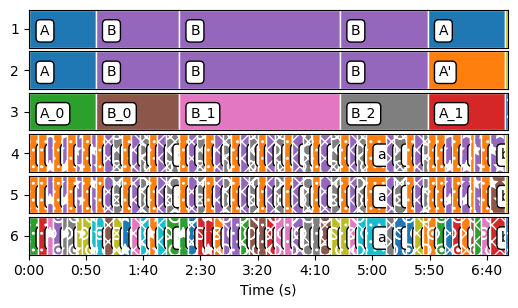

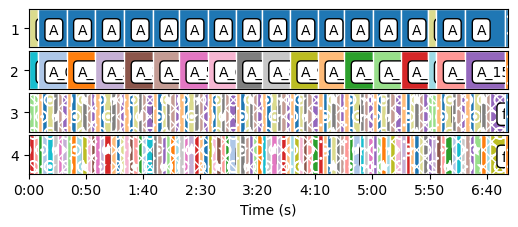

In [2]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [103]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os, pqdm
import xarray as xr, numpy as np
from pqdm.processes import pqdm
from glob import glob
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import bnl
tids = bnl.fio.salami_tids()
o =  bnl.prf.time_salami_track(tids[0])

In [115]:
xr.load_dataarray(o);

In [3]:
from bnl import fio, mtr, prf
from pqdm.processes import pqdm

n_jobs = 7
tids = fio.salami_tids()
pqdm(tids, prf.time_salami_track, n_jobs=n_jobs);

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [4]:
from bnl import fio, mtr, prf

Type:        module
String form: <module 'bnl.fileio' from '/Users/tomxi/code/bnl/bnl/fileio.py'>
File:        ~/code/bnl/bnl/fileio.py
Docstring:   <no docstring>

In [20]:
fio.salami_ref_hiers(20)

{'4': <bnl.core.H at 0x3178582b0>, '6': <bnl.core.H at 0x317858910>}

In [ ]:
# Get the duration of all reference annotations
dur_dict = {}
for tid in fio.salami_tids():
    refs = fio.salami_ref_hiers(tid)
    if len(refs) == 2:
        dur = list(refs.values())[0].T
        dur_dict[tid] = dur


In [26]:
# Save it to a file
import json
with open('salami_durations.json', 'w') as f:
    json.dump(dur_dict, f)
# Load the file
with open('salami_durations.json', 'r') as f:
    dur_dict = json.load(f)

In [27]:
with open('salami_durations.json', 'r') as f:
    dur_dict = json.load(f)

In [29]:
from glob import glob
from tqdm import tqdm
import os
import xarray as xr
## Time to collect
track_results_fpaths = glob('./new_faster_compare/*.nc')

das = []
for fp in tqdm(track_results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


100%|██████████| 883/883 [00:01<00:00, 789.34it/s]


In [30]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./new_faster_compare.nc')

### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

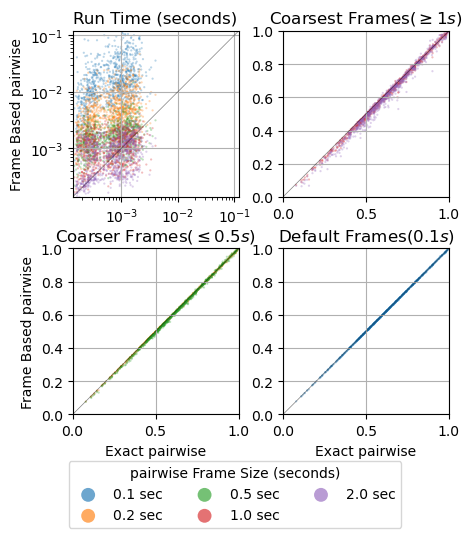

In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from bnl import viz

# Load the data array from the NetCDF file
# results = xr.open_dataarray('./compare_implementation.nc')
# results = xr.open_dataarray('./new_compare.nc')
results = xr.open_dataarray('./new_faster_compare.nc')
metric='pairwise'

fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='run_time', metric=metric), ax=axes[0], log_scale=True
)
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[1,2], ax=axes[1], color_start_idx=3
)
axes[1].set_title('Coarsest Frames($\geq 1s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.2, 0.5], ax=axes[2], color_start_idx=1
)
axes[2].set_title('Coarser Frames($\leq 0.5s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.1], ax=axes[3], color_start_idx=0
)
axes[3].set_title('Default Frames($0.1s$)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel(f'Frame Based {metric}')
axes[2].set_ylabel(f'Frame Based {metric}')
axes[2].set_xlabel(f'Exact {metric}')
axes[3].set_xlabel(f'Exact {metric}')

# Plot the legend with bigger handles
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.65)  # Set transparency for better visibility
leg = fig.legend(handles, labels, 
           loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.17)
          )
leg.set_title(f'{metric} Frame Size (seconds)')

# Set all the handles in the plot back to the smaller size.
for ax in axes:
    handles, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
# fig.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(f'./compare_implementation_{metric}.pdf', transparent=True, bbox_inches='tight')


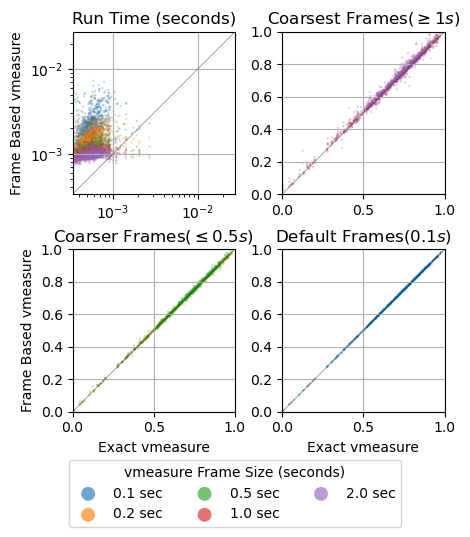

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from bnl import viz

# Load the data array from the NetCDF file
# results = xr.open_dataarray('./compare_implementation.nc')
# results = xr.open_dataarray('./new_compare.nc')
results = xr.open_dataarray('./new_faster_compare.nc')

fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

metric='vmeasure'

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='run_time', metric=metric), ax=axes[0], log_scale=True
)
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[1,2], ax=axes[1], color_start_idx=3
)
axes[1].set_title('Coarsest Frames($\geq 1s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.2, 0.5], ax=axes[2], color_start_idx=1
)
axes[2].set_title('Coarser Frames($\leq 0.5s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.1], ax=axes[3], color_start_idx=0
)
axes[3].set_title('Default Frames($0.1s$)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel(f'Frame Based {metric}')
axes[2].set_ylabel(f'Frame Based {metric}')
axes[2].set_xlabel(f'Exact {metric}')
axes[3].set_xlabel(f'Exact {metric}')

# Plot the legend with bigger handles
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.65)  # Set transparency for better visibility
leg = fig.legend(handles, labels, 
           loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.17)
          )
leg.set_title(f'{metric} Frame Size (seconds)')

# Set all the handles in the plot back to the smaller size.
for ax in axes:
    handles, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
# fig.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')
fig.savefig(f'./compare_implementation_{metric}.pdf', transparent=True, bbox_inches='tight')


### New plots

In [150]:
import numpy as np
import xarray as xr
import seaborn as sns
import json

import matplotlib.pyplot as plt

def plot_runtime_vs_duration(results_path, metric, ax, dur_dict_path='salami_durations.json', q_Factor=10):
    """
    Plots the runtime vs duration for different frame sizes for a given metric.

    Args:
        results_path (str): Path to the xarray data array containing the results.
        metric (str): The metric to plot.
        ax (matplotlib.axes._axes.Axes): The axes to plot on.
        dur_dict_path (str): Path to the JSON file containing the duration dictionary.
    """
    results = xr.open_dataarray(results_path)
    with open(dur_dict_path, 'r') as f:
        dur_dict = json.load(f)

    def get_runtime_vs_duration(results, dur_dict, frame_size, metric):
        x = []
        y = []
        for tid in results['tid'].values:
            tid = str(tid)
            duration = np.round(dur_dict[tid] / q_Factor) * q_Factor
            runtime = results.sel(tid=tid, output='run_time', frame_size=frame_size, metric=metric).item()
            x.append(duration)
            y.append(runtime)

        # x = np.array(x)
        # y = np.array(y)
        # valid_mask = y > 1e-5
        # x = x[valid_mask]
        # y = y[valid_mask]  
        return x, y
    

    frame_sizes = [0, 0.1, 0.2, 0.5, 1, 2]
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    for frame_size, color in zip(frame_sizes, colors):
        x, y = get_runtime_vs_duration(results, dur_dict, frame_size, metric)
        # sns.scatterplot(x=x, y=y, label=f'Frame Size: {frame_size}', color=color, alpha=0.7, ax=ax, legend=False)
        sns.lineplot(x=x, y=y, label=f'{frame_size} sec', color=color, ax=ax, errorbar=('ci', 99.9), legend=False)

    ax.set_title(f'Runtime vs Duration for Different Frame Sizes ({metric})')
    ax.set_xlabel('Duration (seconds)')
    ax.set_yscale('log')
    # ax.grid(True, which="both", ls="--", alpha=0.5)

    

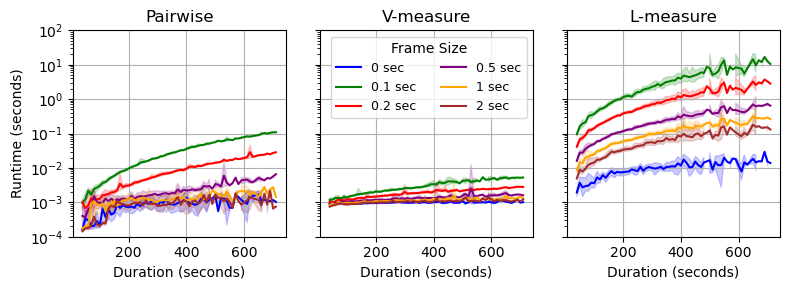

In [161]:

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)  # Adjust figsize as needed

metrics = ['pairwise', 'vmeasure', 'lmeasure']

for i, metric in enumerate(metrics):
    plot_runtime_vs_duration('./new_faster_compare.nc', metric, ax=axes[i])
    axes[i].set_title(f'{metric}')
    axes[i].grid(True)
    # axes[i].sharey(axes[0])  # Share y-axis with the first subplot
    axes[i].set_ylim(1e-4, 100)

axes[0].set_ylabel('Runtime (seconds)')
axes[1].set_xlabel('Duration (seconds)')
axes[1].legend(title='Frame Size', fontsize=9, ncol=2)
axes[0].set_title('Pairwise')
axes[1].set_title('V-measure')
axes[2].set_title('L-measure')

plt.tight_layout()  # Adjust layout to prevent overlap
fig.savefig('./runtime_vs_duration.pdf', transparent=True, bbox_inches='tight')r



### Next plot:
accuracy


In [1]:
# Let's get the accurcay of our results by plotting the residual
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = xr.open_dataarray('./new_faster_compare.nc')

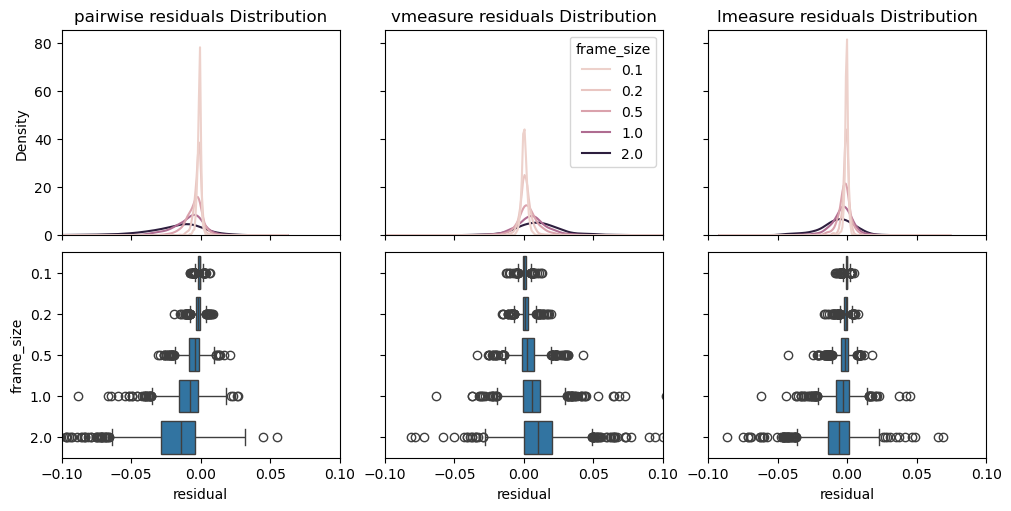

In [18]:
def plot_residuals(results, metric, axes, legend=False):
    """
    Computes the residual between the frame‐based f measure (for frame_size=0) and the f measure for other frame sizes,
    and plots a KDE and a box plot on the provided axes.

    Args:
        results (xarray.DataArray): DataArray with coordinates 'tid', 'frame_size', 'output', and 'metric'.
        metric (str): The metric to plot (e.g., 'pairwise').
        axes (list): List of two matplotlib axes [ax_kde, ax_box] where the plots will be drawn.
    """
    # Get the frameless results (exact measure)
    my_results = results.sel(output='f', metric=metric, frame_size=0)
    # Get results with all frame sizes except 0 and compute residual with the exact measure
    all_results = results.sel(output='f', metric=metric).drop_sel(frame_size=0)
    residual = all_results - my_results
    residual.name = 'residual'
    
    # Convert to a pandas DataFrame for plotting
    residual_df = residual.to_dataframe().reset_index().drop(columns=['output', 'metric'])

    # Plot KDE of residuals for each frame size on the first axis
    sns.kdeplot(
        data=residual_df, x='residual', hue='frame_size',
        common_norm=True, clip=(-0.1, 0.1), common_grid=True, ax=axes[0],
        legend = legend,
    )
    # axes[0].set_yticks([])
    axes[0].set_xlim(-0.1, 0.1)
    axes[0].set_title(f'{metric} residuals Distribution')
    # Plot box plot of residuals grouped by frame size on the second axis
    sns.boxplot(data=residual_df, y='frame_size', x='residual', ax=axes[1], orient='h')
fig, axes = plt.subplots(2, 3, figsize=(10, 5), constrained_layout=True, sharex=True, sharey='row')
plot_residuals(results, 'pairwise', axes[:, 0])
plot_residuals(results, 'vmeasure', axes[:, 1], legend=True)
plot_residuals(results, 'lmeasure', axes[:, 2])

### Next plot:
speed sweeping levels


In [ ]:
# Let's get the results from the depth sweep:


### Next plot:
Figure out what how many times adobe did this evaluation


### Next plot:
speed sweeping levels


## Let's do frame size sensitivity

In [ ]:
# Get a list of frame size, and plot their v-measure, pfc, and l-measure.
import numpy as np
import mir_eval, bnl
import pandas as pd
tid = '776'
salami_hiers = bnl.fio.salami_ref_hiers(tid='776')
adobe_hier = bnl.fio.adobe_hiers(tid='776')
test_fs = np.arange(0.03, 2.01, 0.02)


h1, h2 = salami_hiers
h1, adobe_hier = bnl.mtr.align_hier(h1, adobe_hier)


In [6]:
bnl.fmtr.lmeasure(adobe_hier.itvls, adobe_hier.labels, h1.itvls, h1.labels frame_size=fs)

(0.4758339360180916, 0.37821424882353394, 0.4214450141573712)

In [ ]:
df = pd.DataFrame(results, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity.csv', index=False)

In [10]:
# Doing on est and anno
results = []
for fs in test_fs:
    print(fs)
    # compute the metrics and save result
    _, _, v = mir_eval.segment.vmeasure(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1], frame_size=fs)
    _, _, p = mir_eval.segment.pairwise(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1], frame_size=fs)
    _, _, l = mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, adobe_hier.itvls, adobe_hier.labels, frame_size=fs)
    results.append([fs, v, p, l])

results = np.array(results)
df = pd.DataFrame(results, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity_adobe_776.csv', index=False)
results = results.T

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004
0.32
0.34
0.36000000000000004
0.38
0.4
0.42000000000000004
0.44
0.46
0.48000000000000004
0.5
0.52
0.54
0.56
0.5800000000000001
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.7200000000000001
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.86
0.88
0.9
0.92
0.9400000000000001
0.9600000000000001
0.98
1.0
1.02
1.04
1.06
1.08
1.1
1.12
1.1400000000000001
1.1600000000000001
1.18
1.2
1.22
1.24
1.26
1.28
1.3
1.32
1.34
1.36
1.3800000000000001
1.4000000000000001
1.4200000000000002
1.44
1.46
1.48
1.5
1.52
1.54
1.56
1.58
1.6
1.62
1.6400000000000001
1.6600000000000001
1.6800000000000002
1.7
1.72
1.74
1.76
1.78
1.8
1.82
1.84
1.86
1.8800000000000001
1.9000000000000001
1.9200000000000002
1.94
1.96
1.98
2.0


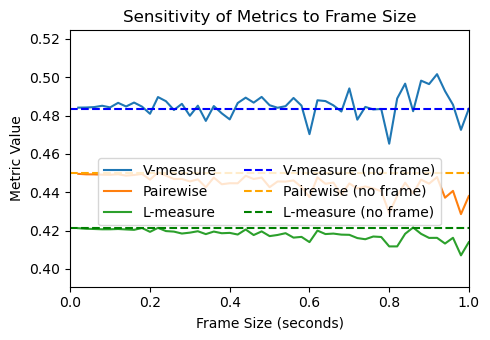

In [16]:
# Get the frameless results too
_, _, my_v = bnl.fmtr.vmeasure(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1])
_, _, my_p = bnl.fmtr.pairwise(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1])
_, _, my_l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, adobe_hier.itvls, adobe_hier.labels)

import matplotlib.pyplot as plt
# results = results.T
plt.figure(figsize=(5, 3.5))
plt.plot(results[0], results[1], label='V-measure')
plt.plot(results[0], results[2], label='Pairewise')
plt.plot(results[0], results[3], label='L-measure')

# plot the frameless results as hlines from 0 to 1
plt.axhline(my_v, color='blue', linestyle='--', label='V-measure (no frame)')
plt.axhline(my_p, color='orange', linestyle='--', label='Pairewise (no frame)')
plt.axhline(my_l, color='green', linestyle='--', label='L-measure (no frame)')
plt.xlabel('Frame Size (seconds)')
plt.ylabel('Metric Value')
plt.title('Sensitivity of Metrics to Frame Size')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.37))
plt.xlim(0,1)
# plt.ylim(0.455, 0.565)
plt.tight_layout()
plt.savefig(f'./fs_sensitivity_adobe.pdf', transparent=True, bbox_inches='tight')

In [ ]:
# Doing on two annotations
results = []
for fs in test_fs:
    # compute the metrics and save result
    _, _, v = mir_eval.segment.vmeasure(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1], frame_size=fs)
    _, _, p = mir_eval.segment.pairwise(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1], frame_size=fs)
    _, _, l = mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels, frame_size=fs)
    results.append([fs, v, p, l])

results = np.array(results).T

In [45]:
# Save the result!
import pandas as pd
# results is a (4, 100) array, where rows are frame_size, vmeasure, pairwise, lmeasure
# We need to transpose it to get (100, 4) for the DataFrame
df = pd.DataFrame(results.T, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity.csv', index=False)

In [17]:
o = pd.read_csv(f'./fs_sensitivity.csv')
o

,frame_size,vmeasure,pairwise,lmeasure
0,0.02,0.537716,0.527019,0.467646
1,0.04,0.538196,0.527106,0.467727
2,0.06,0.537947,0.526762,0.466787
3,0.08,0.539330,0.527297,0.467814
4,0.10,0.533888,0.525532,0.467088
...,...,...,...,...
95,1.92,0.537807,0.515266,0.456873
96,1.94,0.563510,0.517994,0.458106
97,1.96,0.568477,0.526316,0.470278
98,1.98,0.567015,0.525930,0.464258


In [20]:
# Get the frameless results too
_, _, my_v = bnl.fmtr.vmeasure(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1])
_, _, my_p = bnl.fmtr.pairwise(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1])
_, _, my_l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

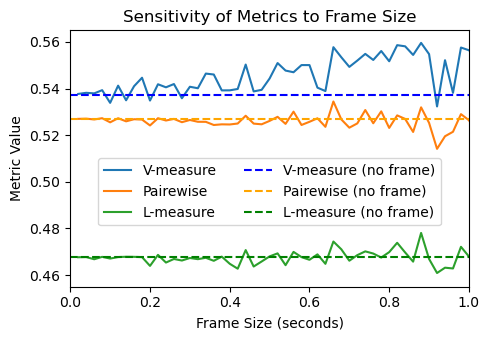

In [25]:
import matplotlib.pyplot as plt
results = o.to_numpy().T
plt.figure(figsize=(5, 3.5))
plt.plot(results[0], results[1], label='V-measure')
plt.plot(results[0], results[2], label='Pairewise')
plt.plot(results[0], results[3], label='L-measure')

# plot the frameless results as hlines from 0 to 1
plt.axhline(my_v, color='blue', linestyle='--', label='V-measure (no frame)')
plt.axhline(my_p, color='orange', linestyle='--', label='Pairewise (no frame)')
plt.axhline(my_l, color='green', linestyle='--', label='L-measure (no frame)')
plt.xlabel('Frame Size (seconds)')
plt.ylabel('Metric Value')
plt.title('Sensitivity of Metrics to Frame Size')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.37))
plt.xlim(0,1)
plt.ylim(0.455, 0.565)
plt.tight_layout()
plt.savefig(f'./fs_sensitivity_anno.pdf', transparent=True, bbox_inches='tight')

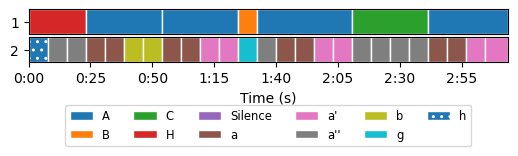

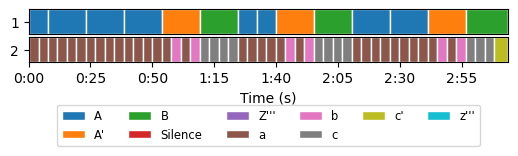

In [50]:
fig, axs = h1.plot(text=False, legend=6, legend_offset=1.5)
fig.savefig(f'./h1.pdf', transparent=True, bbox_inches='tight')
fig, axs = h2.plot(text=False, legend=6, legend_offset=1.5)
fig.savefig(f'./h2.pdf', transparent=True, bbox_inches='tight')

## What's up with the rho being zero in some segment business? Is that even possible?

Let's look at the code where this can be detected

In [2]:
tids = bnl.fio.salami_tids()


for tid in tids:
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
    if len(salami_hiers) < 2:
        continue
    h1, h2 = salami_hiers

    # try l-measure to see if the run time error surfaces
    try:
        _, _, l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)
    except Exception as e:
        print(f"Error for tid {tid}: {e}")
        continue

Error for tid 341: There are segments that are not meeting any other segments, please check your input.


In [1]:
import bnl
h1, h2 = bnl.fio.salami_ref_hiers(tid='341')

In [2]:
bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

(0.0, 0.0, 0.0)

In [3]:
import mir_eval
mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

(0.0, 0.0, 0.0)

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

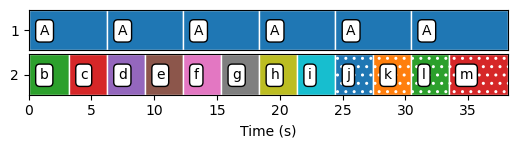

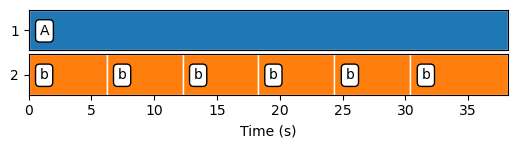

In [5]:
h1.plot();
h2.plot()

## Hierarchical Depth!

Let's get a track from adobe and compare

In [78]:
import bnl, random
from bnl import viz, fio
tids = fio.salami_tids()
random_tid = random.choice(tids)
salami_annos = fio.salami_ref_hiers(tid=random_tid)
salami_adobe = fio.adobe_hiers(tid=random_tid)

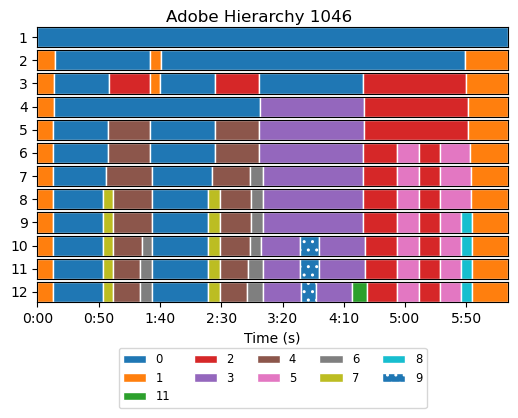

In [79]:
fig, axs = salami_adobe.plot(legend=5, text=False, legend_offset=2, figsize=(5,4.));
fig.suptitle(f'Adobe Hierarchy {random_tid}');

In [97]:
from tqdm import tqdm
import time
import os
import xarray as xr
import numpy as np
import mir_eval
import bnl


def time_depth_sweep(tid, frame_size=0.2, cache_dir='./depth_sweep', retime=False):

    # Check if already timed
    os.makedirs(cache_dir, exist_ok=True)
    output_filepath = os.path.join(cache_dir, f'{tid}.nc')
    if os.path.exists(output_filepath) and not retime:
        print(f"Already timed {tid}.")
        return xr.load_dataarray(output_filepath)

    adobe_hier = bnl.fio.adobe_hiers(tid=str(tid))
    salami_hier = bnl.fio.salami_ref_hiers(tid=str(tid))[0]
    ref, est = bnl.mtr.align_hier(salami_hier, adobe_hier)
     # Save the results to xarray
    result_da = xr.DataArray(
        dims=['level', 'tid', 'version', 'output'],
        coords={'level': range(est.d), 'tid': [tid], 'version': ['mir_eval', 'my'], 'output': ['run_time', 'lp', 'lr', 'lf']},
    )

    for d in range(est.d):
        start_time = time.time()
        mylp, mylr, mylm = bnl.fmtr.lmeasure(ref.itvls, ref.labels, est.itvls[:d+1], est.labels[:d+1])
        my_run_time = time.time() - start_time
        result_da.loc[dict(level=d, tid=tid, version='my')] = [my_run_time, mylp, mylr, mylm]
        
        start_time = time.time()
        melp, melr, melm = mir_eval.hierarchy.lmeasure(ref.itvls, ref.labels, est.itvls[:d+1], est.labels[:d+1], frame_size=frame_size)
        me_run_time = time.time() - start_time
        result_da.loc[dict(level=d, tid=tid, version='mir_eval')] = [me_run_time, melp, melr, melm]

    # Save the results to a NetCDF file
    result_da.to_netcdf(output_filepath)
    print(f"Timed {tid} and saved to {output_filepath}.")
    return result_da

In [98]:
time_depth_sweep(776)

Timed 776 and saved to ./depth_sweep/776.nc.


<xarray.DataArray (level: 12, tid: 1, version: 2, output: 4)> Size: 768B
array([[[[3.42381239e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [1.50418282e-03, 1.93624069e-01, 1.60252169e-04,
          3.20239292e-04]]],


       [[[4.00398731e-01, 5.95915678e-01, 9.44113073e-02,
          1.62998635e-01],
         [1.53207779e-03, 5.94892348e-01, 9.80321599e-02,
          1.68325932e-01]]],


       [[[5.23684263e-01, 3.56278415e-01, 2.91938070e-01,
          3.20915112e-01],
         [1.74784660e-03, 3.57974224e-01, 2.94728328e-01,
          3.23287060e-01]]],


       [[[5.45862913e-01, 3.86389627e-01, 4.04053147e-01,
          3.95024029e-01],
...
         [2.89297104e-03, 4.00189031e-01, 4.51935598e-01,
          4.24491120e-01]]],


       [[[8.82056952e-01, 3.81984312e-01, 4.78468388e-01,
          4.24816885e-01],
         [3.25131416e-03, 3.83657910e-01, 4.80855929e-01,
          4.26792892e-01]]],


       [[[8.69389057e-01, 3.67126990e-01, 4.50610134e-01,
          4.04607147e-01],
         [3.88789177e-03, 3.68939863e-01, 4.53368618e-01,
          4.06819971e-01]]],


       [[[9.20445919e-01, 3.76444222e-01, 4.73235286e-01,
          4.19326787e-01],
         [3.83305550e-03, 3.78165136e-01, 4.75732518e-01,
          4.21374743e-01]]]])
Coordinates:
  * level    (level) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * tid      (tid) int64 8B 776
  * version  (version) <U8 64B 'mir_eval' 'my'
  * output   (output) <U8 128B 'run_time' 'lp' 'lr' 'lf'

In [100]:
from pqdm.processes import pqdm
from bnl import prf

In [102]:
pqdm(tids, prf.time_depth_sweep, n_jobs=8)


QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

Timed 100 and saved to ./depth_sweep/100.nc.
Timed 1005 and saved to ./depth_sweep/1005.nc.
Timed 1006 and saved to ./depth_sweep/1006.nc.
Timed 101 and saved to ./depth_sweep/101.nc.
Timed 1007 and saved to ./depth_sweep/1007.nc.
Timed 1004 and saved to ./depth_sweep/1004.nc.
Timed 1003 and saved to ./depth_sweep/1003.nc.
Timed 10 and saved to ./depth_sweep/10.nc.
Timed 1010 and saved to ./depth_sweep/1010.nc.
Timed 1000 and saved to ./depth_sweep/1000.nc.
Timed 1012 and saved to ./depth_sweep/1012.nc.
Timed 1015 and saved to ./depth_sweep/1015.nc.
Timed 1002 and saved to ./depth_sweep/1002.nc.
Timed 1008 and saved to ./depth_sweep/1008.nc.
Timed 1011 and saved to ./depth_sweep/1011.nc.
Timed 1014 and saved to ./depth_sweep/1014.nc.
Timed 1020 and saved to ./depth_sweep/1020.nc.
Timed 1019 and saved to ./depth_sweep/1019.nc.
Timed 1018 and saved to ./depth_sweep/1018.nc.
Timed 1022 and saved to ./depth_sweep/1022.nc.
Timed 1016 and saved to ./depth_sweep/1016.nc.
Timed 1013 and saved 

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

[<xarray.DataArray (level: 12, tid: 1, version: 2, output: 4)> Size: 768B
 array([[[[7.23854065e-01, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00],
          [1.25598907e-03, 2.92017597e-01, 1.52608846e-04,
           3.05058269e-04]]],
 
 
        [[[1.04781270e+00, 4.46354527e-01, 1.53168100e-01,
           2.28072375e-01],
          [1.45697594e-03, 4.46271387e-01, 1.53918795e-01,
           2.28892628e-01]]],
 
 
        [[[1.14242697e+00, 4.38644168e-01, 1.89867798e-01,
           2.65020896e-01],
          [2.02798843e-03, 4.38665471e-01, 1.89984065e-01,
           2.65138028e-01]]],
 
 
        [[[1.30064702e+00, 4.58745374e-01, 4.70582596e-01,
           4.64588597e-01],
 ...
          [4.70089912e-03, 4.72604828e-01, 5.30369976e-01,
           4.99823945e-01]]],
 
 
        [[[2.08487320e+00, 4.72211602e-01, 5.29430433e-01,
           4.99186704e-01],
          [5.62691689e-03, 4.72714972e-01, 5.29448757e-01,
           4.99475978e-01]]],
 
 
        [[[2.23491096

In [84]:
np.asarray(me_lms) - np.asarray(my_lms)

array([[-0.00066922, -0.00082461, -0.00103225],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854]])

In [85]:
np.asarray(my_lms)

array([[0.92389318, 0.28986803, 0.44128465],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469]])

(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

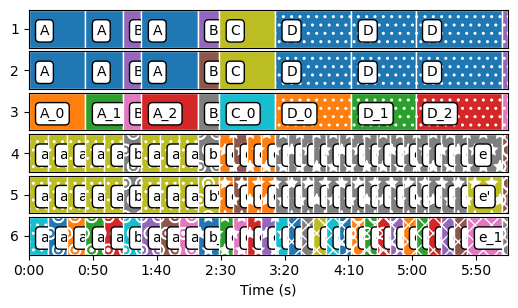

In [28]:
hr.plot()

In [27]:
print(salami_annos[1].T, salami_adobe.T)
hr, he = bnl.mtr.align_hier(salami_annos[0], salami_adobe)
hr = hr.expand()
bnl.mtr.lmeasure(hr, he)

374.6548 374.622


(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)

In [38]:
# Let's get rid of levels and see what happenes


for new_levels in [list(range(x)) for x in range(1, 13)]:
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[0]
(0.34266027780591196, 0.00012623571890510581, 0.0002523784618260422)
[0, 1]
(0.6581936658011615, 0.6795731463818321, 0.6687125683245045)
[0, 1, 2]
(0.6926545525963147, 0.8361129926114956, 0.757652754511553)
[0, 1, 2, 3]
(0.6956489005800305, 0.8792069026274381, 0.77673056028302)
[0, 1, 2, 3, 4]
(0.7054514469663883, 0.9395109533962077, 0.8058291926527081)
[0, 1, 2, 3, 4, 5]
(0.7056384890536834, 0.9415027442302306, 0.8066831920101684)
[0, 1, 2, 3, 4, 5, 6]
(0.6956571429995844, 0.9480288015586521, 0.8024683909441865)
[0, 1, 2, 3, 4, 5, 6, 7]
(0.6850420359263201, 0.9501075221191366, 0.7960905937918014)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
(0.6850744418311399, 0.9508836085628813, 0.7963847938835593)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(0.6853581535152334, 0.9529612492576849, 0.7973045561901873)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(0.6846689158186323, 0.9513795015694538, 0.7962844680495973)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


In [34]:
for x in range(1, len(he.levels) + 1):
    new_levels = list(range(len(he.levels) - x, len(he.levels)))
    # new_levels.reverse()
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[11]
(0.9027779385764622, 0.6228473124352261, 0.7371309728851035)
[10, 11]
(0.8973244392359175, 0.6643869165574928, 0.7634837450903399)
[9, 10, 11]
(0.9000255480312855, 0.6764759985517441, 0.7724009946532311)
[8, 9, 10, 11]
(0.9015321610560229, 0.6851291347050184, 0.7785731599595048)
[7, 8, 9, 10, 11]
(0.8956583777505992, 0.6863716687835092, 0.7771717569377471)
[6, 7, 8, 9, 10, 11]
(0.8989093119210908, 0.7335540979020062, 0.8078571384009704)
[5, 6, 7, 8, 9, 10, 11]
(0.9085913915774447, 0.8676583149135777, 0.8876532087579576)
[4, 5, 6, 7, 8, 9, 10, 11]
(0.9088797688137802, 0.8709141231418888, 0.889492014188317)
[3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8173827484454703, 0.8814992183617402, 0.8482310930772485)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8162596175563637, 0.9537984857846489, 0.8796854586444323)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6829752857248348, 0.9538795555721674, 0.796009695640166)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

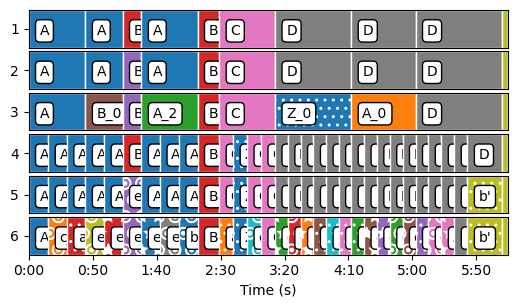

In [36]:
hr.relabel().plot()

In [20]:
bnl.mtr.lmeasure(hr, new_he)

(0.8586787690885265, 0.627727157434456, 0.7252608096499328)

In [13]:
from bnl import metrics, fio
bad_id='1010'
salami_annos = fio.salami_ref_hiers(tid=bad_id)
salami_adobe = fio.adobe_hiers(tid=bad_id)


In [14]:
ref= salami_annos[1]
est= salami_annos[0]
print(metrics.time_lmeasure(ref, est, frame_size=0))
print(metrics.time_lmeasure(ref, est, frame_size=0.5))
print(metrics.time_lmeasure(ref, est, frame_size=0.2))
print(metrics.time_lmeasure(ref, est, frame_size=0.1))

(0.15095305442810059, (0.7366836355959089, 0.736543345875254, 0.7366134840559572))
(0.2579917907714844, (0.7600089438142289, 0.8376851003977025, 0.7969588053590114))
(0.7335591316223145, (0.7558285058507821, 0.834840011231004, 0.7933719332935493))
(1.8798332214355469, (0.7541893548256449, 0.832430667153229, 0.7913808462020459))


In [ ]:
salami_annos[1].labels, salami_annos[0].itvls

In [ ]:
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_annos[0].itvls, salami_annos[0].labels)

In [ ]:
import mir_eval
from mir_eval import hierarchy
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_adobe.itvls, salami_adobe.labels, frame_size=0.1)

In [ ]:
salami_adobe.plot()

In [ ]:
salami_annos[0].T

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures iota alpha and rho.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [ ]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

In [ ]:
hiers[0].plot(text=False)